In [53]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import FormatStrFormatter

In [2]:
import json
import os

In [3]:
# JSON file containing the results for this simulation run
results_file = "/home/brian/git_repos/results-analysis/configs/cv2x.json"

In [4]:
with open(results_file) as results_json:
    config = json.load(results_json)

In [5]:
# Markers to use for this run
markers = [".", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h",
           "H", "+", "x", "X", "D", "d", "|", "_", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [6]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning.
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, lower_bound + quantity * width + 1, width):
        bins.append((low, low + width))
    return bins

In [7]:
def bin_fields(df, fields, bin_width=10, bin_quantity=49):
    """
    Bins multiple dfs into a single dictionary that can be used as an average for multiple fields across multiple
    runs
    :param df: dataframe to bin
    :param fields: fields to be binned.
    :param bin_width: width of each bin
    :param bin_quantity: total number of bins
    :return:
    """
    bins = create_bins(lower_bound=0, width=bin_width, quantity=bin_quantity)
    distances = []
    overall_fields = {}
    for interval in bins:
        upper_b = interval[1]
        distances.append(upper_b)

    for field in fields:
        print("{} being binned".format(field))
        overall_fields[field] = []

    overall_fields["distance"] = distances

    distance_col = config["results"]["distance"]

    for i in range(len(bins)):
        lower_b = bins[i][0]
        upper_b = bins[i][1]
        fields_temp = df[(df[distance_col] >= lower_b) & (df[distance_col] < upper_b)]
        for field in fields:
            if i < len(overall_fields[field]):
                overall_fields[field][i] = (fields_temp[field].mean() + overall_fields[field][i]) / 2
            else:
                overall_fields[field].append(fields_temp[field].mean())

    return overall_fields

In [8]:
def pdr_dist_individual(pdr, distances, label, plot_name, show=True, store=False):
    fig, ax = plt.subplots()

    ax.plot(distances, pdr, label=label, marker=markers[0], markevery=3)

    ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate (PDR) %')
    ax.legend(loc='lower right')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    fig.suptitle(plot_name, fontsize=12)
    
    if show:
        fig.show()
        
    if store:
        fig.savefig("/figures/{}.png".format(plot_name))

In [9]:
def pdr_dist(pdrs, distances, labels, plot_name, show=True, store=False):
    fig, ax = plt.subplots()

    for i in range(len(pdrs)):
        ax.plot(distances, pdrs[i], label=labels[i], marker=markers[i], markevery=3)

    ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate (PDR) %')
    ax.legend(loc='lower right')
    ax.tick_params(direction='in')
    
    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    fig.suptitle(plot_name, fontsize=12)
    
    if show:
        fig.show()
        
    if store:
        fig.savefig("/figures/{}.png".format(plot_name))

In [10]:
def errors_dist_individual(distances, decoded, errors, error_labels, plot_name, show=True, store=False):
    fig, ax = plt.subplots()

    ax.plot(distances, decoded, label="Decoded", marker=self.markers[0], markevery=3)

    for i in range(len(errors)):
        ax.plot(distances, errors[i], label=error_labels[i], marker=self.markers[i+1], markevery=3)

    ax.legend(loc='center left')
    ax.set(xlabel='Distance (m)', ylabel='Messages Decoded')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, step=.1))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    fig.suptitle(plot_name, fontsize=12)
    
    if show:
        fig.show()

    if store:
        fig.savefig("/figures/{}.png".format(plot_name))

In [11]:
def errors_dist(distances, decoded, decoded_labels, errors, error_labels, plot_name, show=True, store=False):
    fig, ax = plt.subplots()

    for i in range(len(decoded)):
        ax.plot(distances, decoded[i], label=decoded_labels[i], marker=self.markers[i], markevery=3)

        for j in range(len(errors[i])):
            ax.plot(distances, errors[i][j], label=error_labels[i][j], marker=self.markers[i + j])

    ax.legend(loc='center left')
    ax.set(xlabel='Distance (m)', ylabel='Messages Decoded')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, step=.1))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))
    
    fig.suptitle(plot_name, fontsize=12)
    
    if show:
        fig.show()
        
    if store:
        fig.savefig("/figures/{}.png".format(plot_name))

### CBR reporting

In [89]:
raw_data_folder = "/home/brian/git_repos/results-analysis/data/raw_data/cv2x/CBR"

In [97]:
first_file = True
merged_df = pd.DataFrame()
for file in os.listdir(raw_data_folder):
    if ".csv" in file:
        result_file = raw_data_folder + "/" + file
        if first_file:
            print(result_file)
            merged_df = pd.read_csv(result_file)
            first_file = False
            break
        else:
            merged_df.append(pd.read_csv(result_file))

/home/brian/git_repos/results-analysis/data/raw_data/cv2x/CBR/run-3-2019-09-30-13:04:21.csv


ParserError: Error tokenizing data. C error: Expected 22 fields in line 314779, saw 23


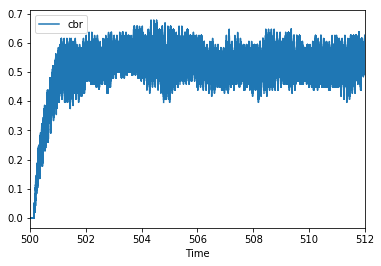

In [14]:
merged_df.plot(x="Time", y="cbr", kind="line")

Need to do some more checks, in much better shape than it was but still some issues here.

- Primarily need to see why we have such a large fluctuation
- Also have to look at why it is a little low, though it also is an average of all vehicles.
- Might find min and max guys

In [15]:
node_23_df = merged_df[(merged_df["NodeID"] == 23) & (merged_df["cbr"] >= 0.0)]

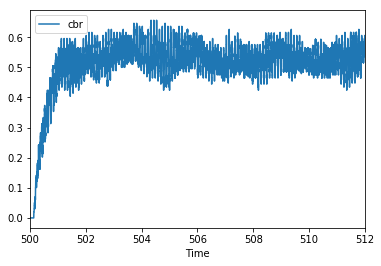

In [16]:
node_23_df.plot(x="Time", y="cbr", kind="line")

Wild fluctuation is a major issue, need to investigate what the story is there

Also extremely noisy, reducing the number of CBR reports is necessary, possibly sending it every 10ms or something like that will improve the quality. 100ms too wide a band.

In [55]:
reduced_merged_df = merged_df[(merged_df["Time"] >= 511) & (merged_df["Time"] <= 512)]

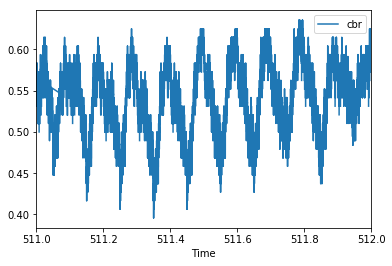

In [56]:
reduced_merged_df.plot(x="Time", y="cbr", kind="line")

In [19]:
print("mean: {}".format(node_23_reduced_df["cbr"].mean()))
print("std: {}".format(node_23_reduced_df["cbr"].std()))
print("median: {}".format(node_23_reduced_df["cbr"].median()))

mean: 0.5427540333368697
std: 0.03656817224064324
median: 0.54166666666667


Text(0.5, 0.98, 'CBR over time')

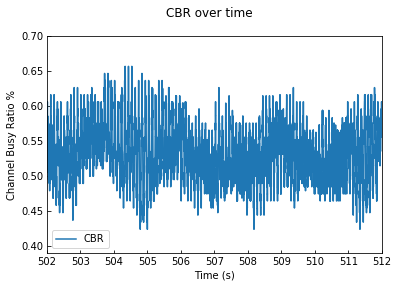

In [20]:
fig, ax = plt.subplots()

ax.plot(node_23_df["Time"], node_23_df["cbr"], label="CBR")

ax.set(xlabel='Time (s)', ylabel='Channel Busy Ratio %')
ax.legend(loc='lower left')
ax.tick_params(direction='in')

ax.set_ylim([0.39, 0.7])
plt.yticks(np.arange(0.4, 0.71, step=0.05))

ax.set_xlim([min(node_23_df["Time"] + 2), (max(node_23_df["Time"]))])
plt.xticks(np.arange(min(node_23_df["Time"] + 2), (max(node_23_df["Time"]) + 1), step=1))

fig.suptitle("CBR over time", fontsize=12)

### Channel Usage

In [21]:
merged_df = merged_df[merged_df["Time"] >= 502]

In [22]:
node_23_df = merged_df[(merged_df["NodeID"] == 23)]

In [23]:
# node_23_df = merged_df

In [24]:
node_23_df["subchannelReceived"] = np.where(node_23_df["sciFailedHalfDuplex"].eq(1.0), -1.0, node_23_df["subchannelReceived"])


/home/brian/anaconda3/envs/results-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
node_23_df_reduced = node_23_df[(node_23_df["Time"] >= 510.0) & (node_23_df["Time"] <= 512)]

In [26]:
small_df = node_23_df_reduced

In [27]:
small_df = small_df.round({'Time': 3})

In [28]:
small_df["subchannelReceived"] = small_df["subchannelReceived"].fillna(-2)

In [29]:
group_df = small_df.groupby("Time")["subchannelReceived"].value_counts().unstack().fillna(0)

In [30]:
group_df.loc[group_df[-1.0] == 1, [0.0, 1.0, 2.0]] = -1

In [31]:
group_df = group_df[[0.0, 1.0, 2.0]]

In [32]:
group_df.head()

subchannelReceived,0.0,1.0,2.0
Time,,,
502.000,1.0,2.0,3.0
502.001,0.0,1.0,1.0
502.002,1.0,1.0,0.0
502.003,0.0,0.0,2.0
502.004,0.0,2.0,0.0


In [33]:
group_df = group_df.T

In [34]:
group_df.index

Float64Index([0.0, 1.0, 2.0], dtype='float64', name='subchannelReceived')

In [35]:
group_df.columns

Float64Index([  502.0, 502.001, 502.002, 502.003, 502.004, 502.005, 502.006,
              502.007, 502.008, 502.009,
              ...
              511.991, 511.992, 511.993, 511.994, 511.995, 511.996, 511.997,
              511.998, 511.999,   512.0],
             dtype='float64', name='Time', length=10001)

In [36]:
group_df = group_df.astype("int")

In [37]:
len(group_df.values[0])

10001

In [38]:
np_xticks = np.arange(min(group_df.columns), max(group_df.columns), 0.01)

In [39]:
np_xticks = np.round(np_xticks, 2)

In [40]:
subframes = list(np.arange(len(group_df.columns), step=20))

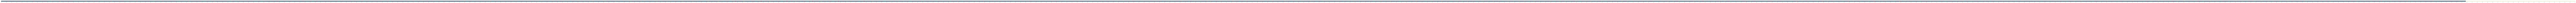

In [45]:
fig, ax = plt.subplots()
im = ax.imshow(group_df.values)

# We want to show all ticks...
ax.set_xticks(np.arange(len(group_df.columns), step=20))
ax.set_yticks(np.arange(len(group_df.index)))

# ax.set_xticklabels(np_xticks)
ax.set_xticklabels(np.array(group_df.columns)[subframes])

plt.rcParams.update({'font.size': 3})

for i in range(len(group_df.values)):
    for j in range(len(group_df.values[i])):
        if group_df.values[i,j] == -1:
            text = ax.text(j, i, "HD", ha="center", va="center", color="Red")
        elif group_df.values[i,j] == 0:
            text= ax.text(j, i, 0, ha="center", va="center", color="Orange")
        else:
            text = ax.text(j, i, group_df.values[i,j], ha="center", va="center", color="green")

# fig.tight_layout()
fig.set_size_inches(600, 100, forward=True)
plt.savefig("Message_history.svg")

In [43]:
merged_df.columns

Index(['EventNumber', 'Time', 'NodeID', 'cbr', 'sciDecoded',
       'sciFailedHalfDuplex', 'sciNotDecoded', 'sciReceived', 'sciSent',
       'senderID', 'subchannelReceived', 'subchannelSent', 'subchannelsUsed',
       'subchannelsUsedToSend', 'tbDecoded', 'tbFailedButSCIReceived',
       'tbFailedDueToNoSCI', 'tbFailedHalfDuplex', 'tbReceived', 'tbSent',
       'txRxDistanceSCI', 'txRxDistanceTB'],
      dtype='object')

In [86]:
sending_info = merged_df[((merged_df["sciSent"] >= 0) | (merged_df["tbSent"] >= 0))][["Time", "NodeID", "sciSent", "tbSent"]]

In [87]:
new_df = sending_info.groupby(["Time", "NodeID"]).sum()

In [88]:
new_df

sciSent  tbSent
Time    NodeID                 
502.000 59          1.0     1.0
        84          1.0     1.0
502.001 191         1.0     1.0
        212         1.0     1.0
502.002 61          1.0     1.0
        76          1.0     1.0
502.003 143         1.0     1.0
        243         1.0     1.0
502.004 78          1.0     1.0
        220         1.0     1.0
        239         1.0     1.0
502.005 1           1.0     1.0
        66          1.0     1.0
        95          1.0     1.0
        165         1.0     1.0
502.006 35          1.0     1.0
        111         1.0     1.0
        152         1.0     1.0
        237         1.0     1.0
        248         1.0     1.0
502.007 244         1.0     1.0
502.008 67          1.0     1.0
        112         1.0     1.0
502.009 226         1.0     1.0
502.010 2           1.0     1.0
        160         1.0     1.0
        195         1.0     1.0
        208         1.0     1.0
502.011 132         1.0     1.0
        194         1.0     1.0
...                 ...     ...
511.991 78          1.0     1.0
511.992 45          1.0     1.0
        82          1.0     1.0
        87          1.0     1.0
        100         1.0     1.0
        205         1.0     1.0
        233         1.0     1.0
511.993 52          1.0     1.0
        104         1.0     1.0
        113         1.0     1.0
        138         1.0     1.0
511.994 24          1.0     1.0
        86          1.0     1.0
511.996 36          1.0     1.0
        135         1.0     1.0
        179         1.0     1.0
        210         1.0     1.0
511.997 119         1.0     1.0
        130         1.0     1.0
        177         1.0     1.0
511.998 202         1.0     1.0
511.999 191         1.0     1.0
        207         1.0     1.0
        223         1.0     1.0
        238         1.0     1.0
512.000 12          1.0     1.0
        54          1.0     1.0
        68          1.0     1.0
        105         1.0     1.0
        195         1.0     1.0

[25195 rows x 2 columns]